In [1]:
import sys

!{sys.executable} -m pip install sagemaker pandas numpy --upgrade
!pip3 install -U sagemaker

  Using cached tzdata-2025.1-py2.py3-none-any.whl.metadata (1.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 91.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 189.0 MB/s eta 0:00:00
Using cached tzdata-2025.1-py2.py3-none-any.whl (346 kB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.240.0
    Uninstalling sagemaker-2.240.0:
      Successfully uninstalled sagemaker-2.240.0


In [2]:
import sagemaker

sess = sagemaker.Session()
bucket = sess.default_bucket()
prefix = "sagemaker/DEMO-xgboost-churn"

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[03/10/25 22:39:23] INFO     Found credentials from IAM Role:                                   ]8;id=390520;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=955397;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


[03/10/25 22:39:25] INFO     Found credentials from IAM Role:                                   ]8;id=818480;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=468801;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

In [3]:
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

[03/10/25 22:39:54] INFO     Found credentials from IAM Role:                                   ]8;id=365604;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=764205;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

In [4]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import CSVSerializer

[03/10/25 22:40:17] INFO     generated new fontManager                                         ]8;id=137417;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=60719;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/font_manager.py#1639\1639]8;;\

In [5]:
s3 = boto3.client("s3")
s3.download_file(
    f"sagemaker-example-files-prod-{sess.boto_region_name}",
    "datasets/tabular/synthetic/churn.txt",
    "churn.txt",
)


[03/10/25 22:40:19] INFO     Found credentials from IAM Role:                                   ]8;id=484171;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=282418;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

In [6]:
churn = pd.read_csv("./churn.txt")
pd.set_option("display.max_columns", 500)
churn


,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,PA,163,806,403-2562,no,yes,300,8.162204,3,7.579174,3.933035,4,6.508639,4.065759,100,5.111624,4.928160,6,5.673203,3,True.
1,SC,15,836,158-8416,yes,no,0,10.018993,4,4.226289,2.325005,0,9.972592,7.141040,200,6.436188,3.221748,6,2.559749,8,False.
2,MO,131,777,896-6253,no,yes,300,4.708490,3,4.768160,4.537466,3,4.566715,5.363235,100,5.142451,7.139023,2,6.254157,4,False.
3,WY,75,878,817-5729,yes,yes,700,1.268734,3,2.567642,2.528748,5,2.333624,3.773586,450,3.814413,2.245779,6,1.080692,6,False.
4,WY,146,878,450-4942,yes,no,0,2.696177,3,5.908916,6.015337,3,3.670408,3.751673,250,2.796812,6.905545,4,7.134343,6,True.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,NH,4,787,151-3162,yes,yes,800,10.862632,5,7.250969,6.936164,1,8.026482,4.921314,350,6.748489,4.872570,8,2.122530,9,False.
4996,SD,140,836,351-5993,no,no,0,1.581127,8,3.758307,7.377591,7,1.328827,0.939932,300,4.522661,6.938571,2,4.600473,4,False.
4997,SC,32,836,370-3127,no,yes,700,0.163836,5,4.243980,5.841852,3,2.340554,0.939469,450,5.157898,4.388328,7,1.060340,6,False.
4998,MA,142,776,604-2108,yes,yes,600,2.034454,5,3.014859,4.140554,3,3.470372,6.076043,150,4.362780,7.173376,3,4.871900,7,True.


col_0,% observations
State,
AK,0.0170
AL,0.0200
AR,0.0220
AZ,0.0180
CA,0.0208
CO,0.0182
CT,0.0178
DC,0.0224
DE,0.0182


col_0,% observations
Phone,
100-2030,0.0002
100-2118,0.0002
100-3505,0.0002
100-5224,0.0002
101-3371,0.0002
...,...
999-3178,0.0002
999-5498,0.0002
999-5816,0.0002


col_0,% observations
Int'l Plan,
no,0.5014
yes,0.4986


col_0,% observations
VMail Plan,
no,0.4976
yes,0.5024


col_0,% observations
Churn?,
False.,0.5004
True.,0.4996


,Account Length,Area Code,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,101.675800,773.791400,226.680000,5.518757,3.50460,5.018902,5.026199,3.140400,5.017557,4.000917,224.790000,5.023490,5.025876,5.475400,4.328242,5.525800
std,57.596762,63.470888,273.998527,3.433485,1.68812,2.195759,2.135487,2.525621,2.127857,1.631001,97.302875,1.748900,1.019302,1.877045,2.440311,2.041217
min,1.000000,657.000000,0.000000,0.000215,0.00000,0.004777,0.004659,0.000000,0.013573,0.008468,0.000000,0.054863,1.648514,0.000000,0.000769,0.000000
25%,52.000000,736.000000,0.000000,2.682384,2.00000,3.470151,3.588466,1.000000,3.529613,2.921998,150.000000,3.873157,4.349726,4.000000,2.468225,4.000000
50%,102.000000,778.000000,0.000000,5.336245,3.00000,4.988291,5.145656,3.000000,5.006860,3.962089,200.000000,5.169154,5.034905,5.000000,4.214058,6.000000
75%,151.000000,806.000000,400.000000,7.936151,5.00000,6.559750,6.552962,5.000000,6.491725,5.100128,300.000000,6.272015,5.716386,7.000000,5.960654,7.000000
max,200.000000,878.000000,1300.000000,16.897529,10.00000,12.731936,13.622097,14.000000,12.352871,10.183378,550.000000,10.407778,8.405644,12.000000,14.212261,13.000000


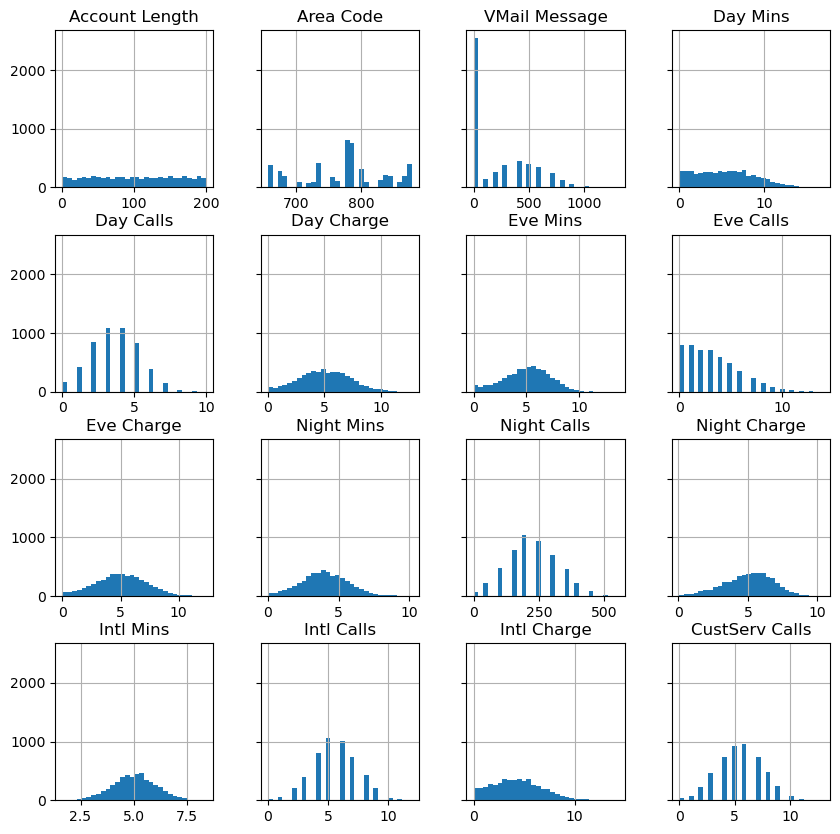

In [7]:
for column in churn.select_dtypes(include=["object"]).columns:
    display(pd.crosstab(index=churn[column], columns="% observations", normalize="columns"))

# Histograms for each numeric features
display(churn.describe())
get_ipython().run_line_magic('matplotlib', 'inline')
hist = churn.hist(bins=30, sharey=True, figsize=(10, 10))

In [8]:
churn = churn.drop("Phone", axis=1)
churn["Area Code"] = churn["Area Code"].astype(object)

In [9]:
churn = churn.drop(["Day Charge", "Eve Charge", "Night Charge", "Intl Charge"], axis=1)


In [10]:
model_data = pd.get_dummies(churn)
model_data = pd.concat(
    [model_data["Churn?_True."], model_data.drop(["Churn?_False.", "Churn?_True."], axis=1)], axis=1
)
model_data = model_data.astype(float)

In [11]:
train_data, validation_data, test_data = np.split(
    model_data.sample(frac=1, random_state=1729),
    [int(0.7 * len(model_data)), int(0.9 * len(model_data))],
)
train_data.to_csv("train.csv", header=False, index=False)
validation_data.to_csv("validation.csv", header=False, index=False)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [12]:
boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "train/train.csv")
).upload_file("train.csv")
boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "validation/validation.csv")
).upload_file("validation.csv")


[03/10/25 22:42:09] INFO     Found credentials from IAM Role:                                   ]8;id=975781;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=612197;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

[03/10/25 22:42:10] INFO     Found credentials from IAM Role:                                   ]8;id=749124;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=768621;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

In [13]:
container = sagemaker.image_uris.retrieve("xgboost", sess.boto_region_name, "1.7-1")
display(container)

[03/10/25 22:42:24] INFO     Ignoring unnecessary instance type: None.                            ]8;id=634847;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=852378;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

'683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.7-1'

In [14]:
s3_input_train = TrainingInput(
    s3_data="s3://{}/{}/train".format(bucket, prefix), content_type="csv"
)
s3_input_validation = TrainingInput(
    s3_data="s3://{}/{}/validation/".format(bucket, prefix), content_type="csv"
)

In [15]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/{}/output".format(bucket, prefix),
    sagemaker_session=sess,
)
xgb.set_hyperparameters(
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.8,
    verbosity=0,
    objective="binary:logistic",
    num_round=100,
)

xgb.fit({"train": s3_input_train, "validation": s3_input_validation})


# In[ ]:


xgb_predictor = xgb.deploy(
    initial_instance_count=1, instance_type="ml.m4.xlarge", serializer=CSVSerializer()
)



[03/10/25 22:42:52] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=113821;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=866263;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=775600;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=946291;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\
                             sagemaker-xgboost-2025-03-10-22-42-52-105                                             

2025-03-10 22:42:53 Starting - Starting the training job...
..25-03-10 22:43:07 Starting - Preparing the instances for training.
..25-03-10 22:43:35 Downloading - Downloading input data.
.....03-10 22:44:05 Downloading - Downloading the training image.
[2025-03-10 22:45:26.406 ip-10-0-219-230.ec2.internal:8 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2025-03-10 22:45:26.441 ip-10-0-219-230.ec2.internal:8 INFO profiler_config_parser.py:111] User has disabled profiler.
[2025-03-10:22:45:26:INFO] Imported framework sagemaker_xgboost_container.training
[2025-03-10:22:45:26:INFO] Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
[2025-03-10:22:45:26:INFO] No GPUs detected (normal if no gpus installed)
[2025-03-10:22:45:26:INFO] Running XGBoost Sagemaker in algorithm mode
[2025-03-10:22:45:26:INFO] Determined 0 GPU(s) available on the instance.
[2025-03-10:22:45:26:INFO] Determined delimiter of CSV input is ','
[2025-03-10:22:45:26:

[03/10/25 22:46:09] INFO     Creating model with name: sagemaker-xgboost-2025-03-10-22-46-09-407    ]8;id=269719;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=185890;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\

[03/10/25 22:46:10] INFO     Creating endpoint-config with name                                     ]8;id=835222;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=476441;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#5937\5937]8;;\
                             sagemaker-xgboost-2025-03-10-22-46-09-407                                             

                    INFO     Creating endpoint with name sagemaker-xgboost-2025-03-10-22-46-09-407  ]8;id=194535;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=571847;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4759\4759]8;;\

--------!

In [16]:


def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ""
    for array in split_array:
        predictions = "".join([predictions, xgb_predictor.predict(array).decode("utf-8")])

    return predictions.split("\n")[:-1]


predictions = predict(test_data.to_numpy()[:, 1:])

